Esta forma esta bien para entrenar los modelos basados en tensores, pero no vale para pytorch.

# 1. Descargamos las librerias necesarias para la realización del script

In [ ]:
################  TRANSFORMERS ################
!pip  install transformers --quiet
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import Trainer
!pip install transformers[torch] --quiet
!pip install accelerate -U --quiet
################  DATASETS ################
!pip install Datasets --quiet
from datasets import DatasetDict, Dataset
# Librería para montar drive en GoogleColab y descargar el dataset que vamos a usar:
from google.colab import drive  #Montador de drive
################  PYSENTIMIENTO ################
!pip install pysentimiento --quiet
from pysentimiento.preprocessing import preprocess_tweet

In [ ]:
#from transformers import AutoModelForSequenceClassification
#from transformers import TFDistilBertForSequenceClassification
#from transformers import TextClassificationPipeline

# Import other modules
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive  #Montador de drive
from sklearn.model_selection import train_test_split
import gc

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 2. Importamos el dataset



In [ ]:
# 1.Obtenemos de drive el dataframe con el que vamos a trabajar
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/datasets/01 Exist2021_Esp.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#2.Cambiamos el nombre de las columnas e eliminamos aquellas que no necesitamos como el id, el testcase, etc. Nos vamos a quedar tan solo con el texto y las labels
columns_to_remove = ['test_case', 'id', 'source','language','task1']
df = df.rename(columns = {"task2": "label"}).drop(columns=columns_to_remove, axis=1)
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,sexual-violence
1,"@lindagisela74 Que rica putita obediente, afor...",stereotyping-dominance
2,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist
3,las cosas q sueño son indicios de que yo enrea...,non-sexist
4,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist


In [ ]:
# 3.Necesitamos saber cuales son los valores únicos de nuestras etiquetas para cambiarlas a valores numéricos:
Etiquetas = df['label'].unique()

In [ ]:
Etiquetas

array(['sexual-violence', 'stereotyping-dominance', 'non-sexist',
       'misogyny-non-sexual-violence', 'ideological-inequality',
       'objectification'], dtype=object)

In [ ]:
#4. Cambiamos los valores nominales de sexista y no sexista a valores numéricos
df['label'] = df['label'].replace(['non-sexist','sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality','objectification'],[0, 1, 2 , 3, 4, 5])

In [ ]:
#5.Eliminamos cualquier fila que haya podido quedar en blanco:
df = df.dropna()

In [ ]:
df['text'].apply(preprocess_tweet)

0        Nadie te va a tratar tan bien como un hombre q...
1        @usuario Que rica putita obediente, afortunado...
2        @usuario Yo lo hice a los 18 años por la carre...
3        las cosas q sueño son indicios de que yo enrea...
4        Pero a la niña le gustó desde que lo vió, así ...
                               ...                        
11324    @usuario @usuario @usuario Disgustas a todos c...
11325    ¿Cómo estás, una mujer adulta que es literalme...
11326    Otro buscador de oro que busca ganar dinero co...
11327    Tenemos otra primera vez!! Tan feliz de ver a ...
11328    Cuando Simps &amp; Beta puede ejecutar sistema...
Name: text, Length: 11329, dtype: object

## 2.1 - Separamos el dataset en varios conjuntos (Train, Validación y Test)

In [ ]:
# Dividiremos el dataset en el 80% para el entrenamiento, el 10% para el proceso de validation, y un 10% para testear los resultados del modelo.
train_df, valtest_df = train_test_split(df, test_size = 0.2, random_state = 42)
val_df, test_df = train_test_split(valtest_df, test_size = 0.5, random_state = 42)
train_df.shape, val_df.shape, test_df.shape

((9063, 2), (1133, 2), (1133, 2))

In [ ]:
train = Dataset.from_pandas(train_df)
validation = Dataset.from_pandas(val_df)
test = Dataset.from_pandas(test_df)

In [ ]:
#Lo convertimos en un solo dataset:

tweets = DatasetDict({
  'train': train,
  'val': validation,
  'test': test})
# Dataset.from_pandas genera una columna denominada index_0 qeu debemos eliminar:

tweets = tweets.remove_columns(["__index_level_0__"])

In [ ]:
tweets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
})

In [ ]:
# Definiremos un diccionario para poder traduccir las etiquetas o labels que nos devuelva nuestro modelo:
Etiqueta_dato = {}
Dato_Etiqueta = {}

etiquetas = ['non-sexist','sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality','objectification']
for dato, nombre_etiqueta in enumerate(etiquetas):
  Dato_Etiqueta[nombre_etiqueta] = str(dato)
  Etiqueta_dato[str(dato)]= nombre_etiqueta


Etiqueta_dato , Dato_Etiqueta

({'0': 'non-sexist',
  '1': 'sexual-violence',
  '2': 'stereotyping-dominance',
  '3': 'misogyny-non-sexual-violence',
  '4': 'ideological-inequality',
  '5': 'objectification'},
 {'non-sexist': '0',
  'sexual-violence': '1',
  'stereotyping-dominance': '2',
  'misogyny-non-sexual-violence': '3',
  'ideological-inequality': '4',
  'objectification': '5'})

# 3.Descarga del modelo y su tokenizador



In [ ]:
#Especificamos el modelo a adaptar a nuestro problema:
model_ckpt = "pysentimiento/robertuito-base-uncased"
# y descargamos su tokenizador:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#Debemos definir una función para tokenizar el dataset y que sea gestionable por nuestro modelo:
def tokenizador(batch):
  return tokenizer( batch["text"], padding = True,  max_length=128, truncation = True)

In [ ]:
# Para poder aplicarlo al todo el diccionario utilizaremos la función map:
tweets_Encoded = tweets.map(tokenizador, batched = True,batch_size = None )

Map:   0%|          | 0/9063 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [ ]:
tweets_Encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1133
    })
})

In [ ]:
#Necesitamos que los objetos sean de tipo torch
tweets_Encoded.set_format("torch", columns = ["label","input_ids", "attention_mask"])

In [ ]:
#Debemos comprobar que la ejecucion se vaya a realizar sobre cuda:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#Obtenemos el modelo con una cabeza de clasificación:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = 6, label2id = Etiqueta_dato, id2label = Dato_Etiqueta).to(device)

## 3.1 - Definimos las métricas de evaluación y los hiperparámetros:

### 3.1.1 Métricas:

In [ ]:
# 1. Definimos la función de evaluación para calcular tanto el f1 como el accuracy:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
#2. Definimos los hiperparametros para el entrenamiento:
#Empezamos con un batchsize y un número de épocas aleatorio:
batch_size = 16
num_epochs = 4

# Name of the model (to be uploaded to Huggingface)
model_name = f"{model_ckpt}-finetuned-sexism_detection"

# Specify the path to store the fine-tuned model
path_model = '/content/drive/MyDrive/'

# Training argument
training_args = TrainingArguments(
  output_dir = os.path.join(path_model, model_name),
  num_train_epochs = num_epochs,
  learning_rate = 2e-5,
  per_device_train_batch_size = batch_size,
  per_device_eval_batch_size = 64,
  weight_decay = 0.01,
  evaluation_strategy = "epoch",
  load_best_model_at_end = True,
  push_to_hub = False,
  save_strategy = "epoch")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Generamos un objeto Trainer para el entrenamiento:
trainer = Trainer(
  model = model,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = tweets_Encoded["train"],
  eval_dataset = tweets_Encoded["val"],
  tokenizer = tokenizer)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#5.Entrenamos nuestro modelo:
trainer.train()

{'loss': 1.1189, 'grad_norm': 9.100685119628906, 'learning_rate': 1.559082892416226e-05, 'epoch': 0.8818342151675485}
{'eval_loss': 0.9156618118286133, 'eval_accuracy': 0.6654898499558694, 'eval_f1': 0.6607906988791018, 'eval_runtime': 3.9474, 'eval_samples_per_second': 287.027, 'eval_steps_per_second': 4.56, 'epoch': 1.0}
{'loss': 0.7897, 'grad_norm': 13.257213592529297, 'learning_rate': 1.1181657848324516e-05, 'epoch': 1.763668430335097}
{'eval_loss': 0.9015979766845703, 'eval_accuracy': 0.6875551632833187, 'eval_f1': 0.6870033266218418, 'eval_runtime': 3.977, 'eval_samples_per_second': 284.89, 'eval_steps_per_second': 4.526, 'epoch': 2.0}
{'loss': 0.601, 'grad_norm': 11.307615280151367, 'learning_rate': 6.772486772486773e-06, 'epoch': 2.6455026455026456}
{'eval_loss': 0.9511217474937439, 'eval_accuracy': 0.6875551632833187, 'eval_f1': 0.6876225049973623, 'eval_runtime': 3.9927, 'eval_samples_per_second': 283.768, 'eval_steps_per_second': 4.508, 'epoch': 3.0}
{'loss': 0.4783, 'grad_n

TrainOutput(global_step=2268, training_loss=0.7072585945196673, metrics={'train_runtime': 456.5374, 'train_samples_per_second': 79.406, 'train_steps_per_second': 4.968, 'train_loss': 0.7072585945196673, 'epoch': 4.0})

# Matriz de Confusión

In [ ]:
preds_output = trainer.predict(tweets_Encoded["val"])

In [ ]:
preds_output.metrics

{'test_loss': 0.9015979766845703,
 'test_accuracy': 0.6875551632833187,
 'test_f1': 0.6870033266218418,
 'test_runtime': 3.8808,
 'test_samples_per_second': 291.952,
 'test_steps_per_second': 4.638}

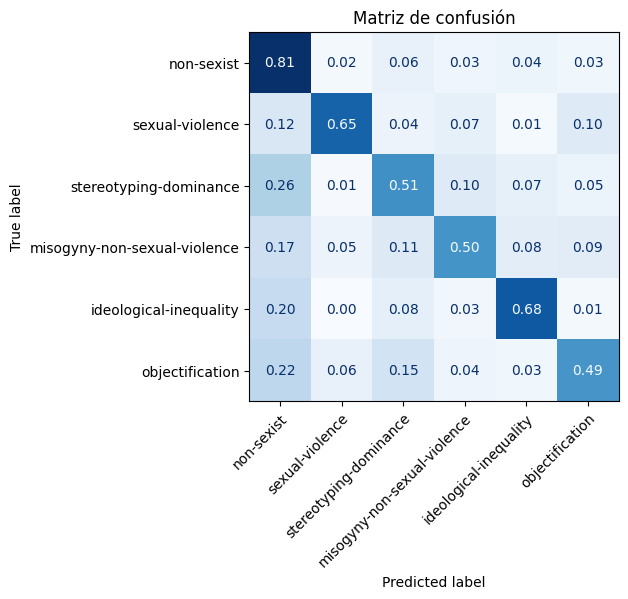

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
cm = confusion_matrix(tweets_Encoded["val"]['label'], y_preds, normalize="true")
labels = ['non-sexist', 'sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality', 'objectification']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Crear una figura y un eje
fig, ax = plt.subplots()
# Plotear la matriz de confusión
disp.plot(cmap="Blues", values_format=".2f", colorbar=False, ax=ax)
# Ajustar las etiquetas de la línea x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.title("Matriz de confusión")
plt.show()

In [ ]:
preds_output = trainer.predict(tweets_Encoded["test"])
preds_output.metrics



{'test_loss': 0.909618616104126,
 'test_accuracy': 0.6796116504854369,
 'test_f1': 0.6775425263934126,
 'test_runtime': 3.9065,
 'test_samples_per_second': 290.031,
 'test_steps_per_second': 4.608}

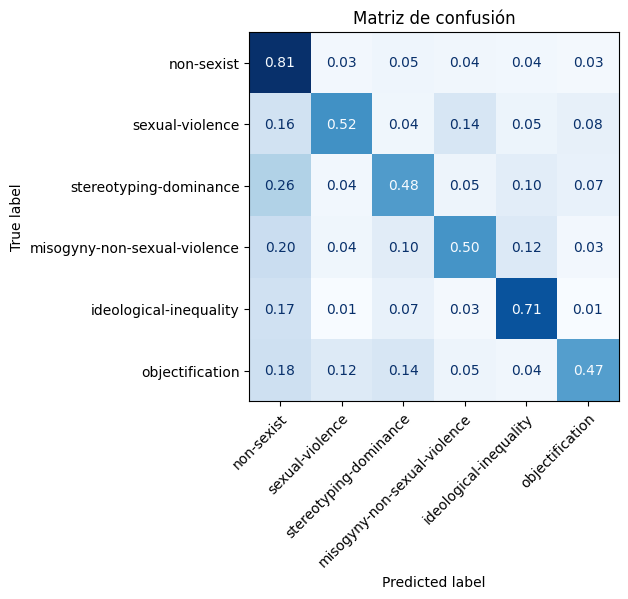

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
cm = confusion_matrix(tweets_Encoded["test"]['label'], y_preds, normalize="true")
labels = ['non-sexist', 'sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality', 'objectification']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Crear una figura y un eje
fig, ax = plt.subplots()
# Plotear la matriz de confusión
disp.plot(cmap="Blues", values_format=".2f", colorbar=False, ax=ax)

# Ajustar las etiquetas de la línea x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.title("Matriz de confusión")
plt.show()

# Análisis del validation loss

In [ ]:
#Análisis de la perdida del modelo:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
tweets_Encoded["val"] = tweets_Encoded["val"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [ ]:
def label_int2str(label):
    return Etiqueta_dato[str(label)]

In [ ]:
tweets_Encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tweets_Encoded["val"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
179,"#NoEsBromaY como si no fuera suficiente, tendrá que pagar una pensión alimenticia ...https://t.co/5fYh13p2WO",ideological-inequality,non-sexist,6.244861
523,Y voy por un culo así el año que viene https://t.co/n41R03x8u6,objectification,non-sexist,6.155214
251,"@AlleyDalley Tuvo que ser un puritano expresando impulsos reprimidos, estoy seguro",sexual-violence,non-sexist,6.072658
149,"https://t.co/pBzAmUNOO3Esta noticia me rompió el corazón. Piensa mi amigo, y si te pasara a ti o a algún ser querido seguirias siendo un pagafantas? Razón del porqué el #MeToo es una aberración",ideological-inequality,non-sexist,5.962391
342,@Sniper64286433 Todavía no. Hasta ahora sólo el MeToo Soy una tarjeta de víctima,ideological-inequality,non-sexist,5.932052
215,@Benholm @hari_fightclub @margaritaevna95 Es una táctica clásica usada contra las mujeres durante milenios para debilitarlas reduciéndolas a objetos. Así que esa es mi desvarío feminista.. No todo el feminismo es malo. Algunas observaciones siguen siendo válidas incluso ahora,objectification,ideological-inequality,5.224484
43,"Sí, sabemos lo borracho que era y lo que sigue siendo Killary, esperando a que su hígado se entregue.",misogyny-non-sexual-violence,non-sexist,5.170043
364,https://www.mediterraneodigital.com/espana/cataluna/los-terroristas-de-barcelona-se-iban-de-putas-mientras-cobraban-ayudas-sociales.html,objectification,non-sexist,5.018274
847,@Imthissexyinrl @soulbrotha215 @Inflatable8D No te culpo en absoluto. Yo tampoco querría ir allí. Parece que el período de mujeres &amp; niños no es seguro allí.,misogyny-non-sexual-violence,non-sexist,4.808134
33,Sodomizar el sábado es maravilloso. Necesito a alguien(s) con quien sodomizar. https://t.co/j4UB1rHyBW,sexual-violence,non-sexist,4.788781


In [ ]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas
pd.set_option('display.width', None)  # Ancho de la pantalla no limitado
pd.set_option('display.max_colwidth', None)  # Mostrar el texto completo en la
# Ordena y muestra las primeras 10 filas
df_test.sort_values("loss", ascending=True).head(10)


,text,label,predicted_label,loss
905,"Es seguro decir que 2020 fue un año de gran importancia histórica. ¡Gracias por compartir la esperanza que nos dio Jesucristo para ayudar a estos hombres, mujeres y niños a hacer sus propias historias! Disfrute de nuestro Informe Anual de 2020 a continuación. #HistoryInTheMakinghttps://t.co/33UoegDbZ5 https://t.co/NzTleNfLTv",non-sexist,non-sexist,0.007004
1019,Quito merece ser lo que fue. Recuperémoste la libertad y el trabajo para rescatar a la ciudad del abandono y la desidia. La @CorteConstEcu debe devolver a lo s quiteños sus derechos. #TrabajoYLibertad #DerechosYTrabajo https://t.co/qIue7KS0Gh,non-sexist,non-sexist,0.008439
818,Ya no tiene sentido hablar de ellos. @AKinkhabwala está dando la vuelta a la esquina! Sigue con el gran trabajo Aditi! #Browns https://t.co/qRDglWKqyN,non-sexist,non-sexist,0.008799
964,"@rianjohnson todo el mundo hablando de las guerras estelares, y te lo mereces, pero solo quiero dar las gracias por esto. MASTERPIECE! https://t.co/mFpHo9VWK7",non-sexist,non-sexist,0.008897
187,"¡ EL COMPROMISO DE HACER MEJOR !Hoy se celebra el día Internacional de Voluntariado, es por ello que quiero saludar muy afectuosamente a todos los hombres y mujeres, que forman parte de las ONG's de la Provincia, que trabajan en la emergencia. https://t.co/YD8lXuDDBG",non-sexist,non-sexist,0.009359
141,$1.50 El Misterio de la Providencia (Puritano de Vintage) por John Flavel https://t.co/TS1sNw3jIC#kindledeales https://t.co/hZGQ6rYEoB,non-sexist,non-sexist,0.009996
820,"Si sales y haces que las cosas buenas sucedan, llenarás de esperanza al mundo y a tú mismo – Barack Obama¿Y si lo intentas?Atrévete, visítanos en https://t.co/QLH9voSqjV#Sanaccion #BarackObama #bueno #esperanza #mundo #Felicidad #Iluminación #Empoderamiento #crecimiento https://t.co/4YArmCNvr7",non-sexist,non-sexist,0.010011
165,"@johon_gutierrez Q horror, el tipo no es mi ídolo y muy aparte de su pocision política deseo q se recupere, odiar a alguien por q piensa distinto no nos hace mejores personas y aunque el tipo no sea el gran artista como ser humano merece respeto",non-sexist,non-sexist,0.010030
77,"Popeye' el cachorro puede ser fuerte, pero tiene Wellesley y Dover primeros respondedores para agradecer por sacarlo del agua helada del río Charles. https://t.co/O8cn4HCkJp",non-sexist,non-sexist,0.010091
853,"@funkymxnks Hombre pero noel no se refería a los conciertos del 94 95... que tb por eso aclaro que la Mayoría de veces, el unplugged fue porque no se sentía cómodo haciendo un acústico y como se comunican tan bien diría pos me emborracho y lo veo desde el palco a tomar x culo el enano",non-sexist,non-sexist,0.010480


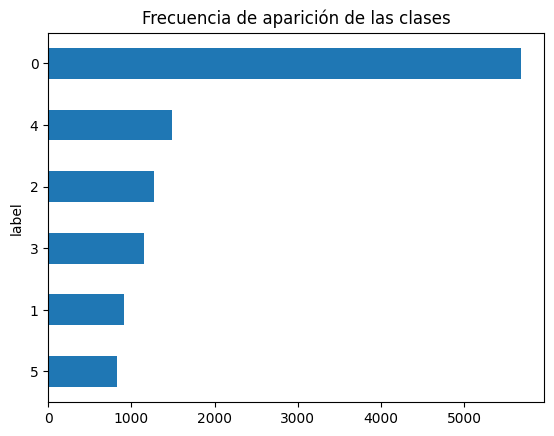

In [ ]:
df['label'].value_counts(ascending= True).plot.barh()
labels = ['non-sexist', 'sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality', 'objectification']
plt.title("Frecuencia de aparición de las clases")
plt.show()

In [ ]:
model.save_pretrained(
  os.path.join(path_model, 'Twitter/twhin-finetuned-detección-sexismo'))
tokenizer.save_pretrained(
    os.path.join(path_model, 'Twitter/twhin-finetuned-detección-sexismo'))

('/content/drive/MyDrive/Twitter/twhin-finetuned-detección-sexismo/tokenizer_config.json',
 '/content/drive/MyDrive/Twitter/twhin-finetuned-detección-sexismo/special_tokens_map.json',
 '/content/drive/MyDrive/Twitter/twhin-finetuned-detección-sexismo/tokenizer.json')